# Readme
This the notebook MM805 Assignment. 

# Requirement to run this notebook
1. Python 3.8
2. Setup Python virtual environment 
```py
    python3.8 -m venv .venv
    . .venv/bin/activate
    pip install --upgrade pip
```
3. Install required packages `pip install -r requirements.txt`



# Q1. (40 points) Feature extraction and matching

   (use the images from https://sourceforge.net/projects/adobedatasets.adobe/files/adobe_panoramas.tgz/download)  
    a. (10 points) Select and implement one of the point feature detectors we have explained or use other methods you learned about. (Make sure to implement the feature detector yourself). Explain your selected detector and show the results.   
    b. (20 points) Implement a simple feature matching by using two feature descriptors of your choice (you can use the available feature descriptors in OpenCV or Matlab). Compare the two feature descriptors and the matching results on a few different images.  
    c. (10 points) Instead of finding feature points independently in multiple images and then matching them, find features in the first image of a video or image sequence and then re-locate the corresponding points in the next frames using search and gradient descent (Shi and Tomasi 1994). When the number of tracked points drops below a threshold or new regions in the image become visible, find additional points to track.

## 1a.  Harris Corner Point detection

The feature I implemented is Harris corner point. The logic is based on [wikipedia](https://en.wikipedia.org/wiki/Corner_detection#The_Harris_&_Stephens_/_Shi%E2%80%93Tomasi_corner_detection_algorithms)


The key function is `get_harris_points`, the detail code can be found in assignment_code.py ane extra function `display_corner_points` is written for display finding point on image as red point.

In [4]:
import numpy as np
import cv2
from pprint import pprint
from scipy import ndimage
from skimage.feature import corner_peaks
from scipy import signal



def imfilter(I, filter)->np.ndarray:
    # I_f = ndimage.filters.correlate(I, weights=filter, mode='constant')
    I_ =  signal.convolve2d(I, filter, boundary='symm', mode='same')
    return I_


def harris_corner_points(I, k=0.05):

    # check image and convert to gray and normalize
    if len(I.shape) == 3 and I.shape[2] == 3:
        I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    if I.max() > 1.0:
        I = I / 255.0

    # Step 1 calcualte Axx, Axy and Ayy
    
    # Step 1.1 calculate Ix, Iy
    # apply soble filter for quick calculation
    filter_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / \
        8.0  # sobel filter for x derivative
    filter_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) / \
        8.0  # sobel filter for y derivative

    Ix = imfilter(I, filter_x)
    Iy = imfilter(I, filter_y)
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    window = np.ones((3, 3))

    Axx = imfilter(Ixx, window)
    Axy = imfilter(Ixy, window)
    Ayy = imfilter(Iyy, window)

    # Step 2 calculate response
    # determinant
    detA = Axx * Ayy - Axy ** 2
    # trace
    traceA = Axx + Ayy
    # response
    response = detA - k * traceA ** 2

    # step 3. Get points location(x,y)
    points = corner_peaks(response,min_distance=4)
    # points = get_coordinate(response,I.shape)

    return points

def display_corner_points(org_img:np.ndarray, points, output_name):
    bool_arr = np.zeros(org_img.shape[:2],dtype=np.int8)
    bool_arr = np.bool8(bool_arr)
    
    # pprint(bool_arr)
    for (x,y) in points:
        bool_arr[x,y] = True
    
    # pprint(bool_arr)
    org_img[bool_arr]=[0,0,255]
    cv2.imwrite(output_name, org_img)



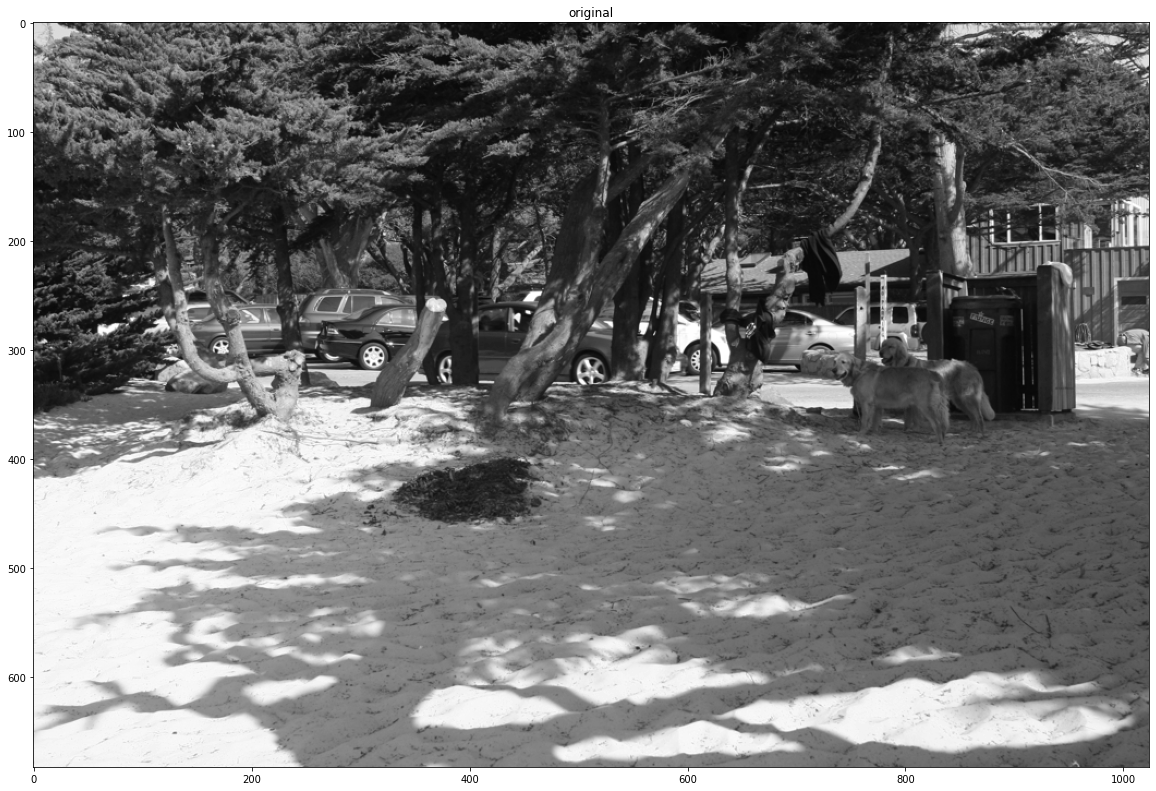

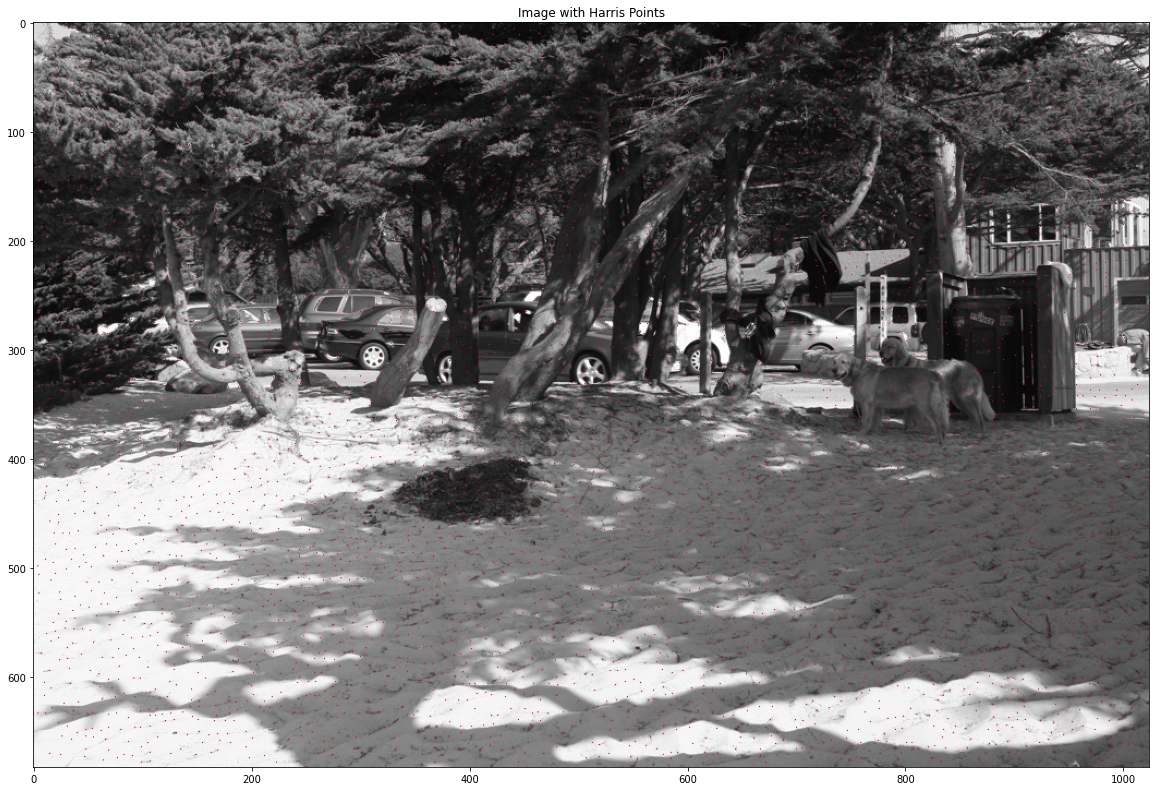

In [5]:
# showing result
import matplotlib.pyplot as plt

image_name = "data/carmel/carmel-00.png"
image = cv2.imread(image_name,cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(20, 15))
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title("original")
plt.show()


I = cv2.imread(image_name)
grey = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
grey = grey / 255.0
points = harris_corner_points(grey)
output_name = f"./output/a_harris_output.jpg"
display_corner_points(I,points,output_name)
image2 = cv2.imread(output_name)
image2 = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 15))
plt.imshow(image2)
plt.title("Image with Harris Points")
plt.show()



## 1B. Feature Matching
Question: Implement a simple feature matching by using two feature descriptors of your choice (you can use the available feature descriptors in OpenCV or Matlab). Compare the two feature descriptors and the matching results on a few different images. 

Answer:  

The matching function is usign K near neighbour algorithm. The function accept descriptor name and display the result.

The first descriptor ORB feature descriptor and the second one is SIFT feature descriptor. 

The ORB gives better result, for example the table corner is a very good candidate for key points but it is not shows in the top 300 points in the SIFT result.

Accredit: the ploting function has refereced some logic from opencv example code.

In [6]:
import numpy as np
import cv2
from pprint import pprint
from scipy import ndimage
from skimage.feature import corner_peaks
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

def knn_match(img1,img2,descriptor='sift',show_limit=100):
    '''Only support sift and orb as descriptor'''

    # Initiate SIFT detector
    if descriptor == 'sift':
        sift = cv2.SIFT_create()
        # find the keypoints and descriptors with SIFT
        # descriptors are 128 dimention histogram,
        # to compare descriptors using Knn 
        kp1, des1 = sift.detectAndCompute(img1,None)
        kp2, des2 = sift.detectAndCompute(img2,None)
    elif descriptor == 'orb':
        # Initiate ORB detector
        orb = cv2.ORB_create()
        # find the keypoints and descriptors with ORB
        kp1, des1 = orb.detectAndCompute(img1,None)
        kp2, des2 = orb.detectAndCompute(img2,None)
    else:
        print(f"Unsupported descriptor {descriptor}")
        return

    # KNN match 
    k = 2
    m = des1.shape[0]
    n = des2.shape[0]
    
    matches = list()
    dis_list = pairwise_distances(des1,des2,metric='euclidean')
    for i in range(m):
        d_list = list()
        arr = dis_list[i,:]
        arr = np.argsort(arr,axis=0)[0:k]
        for j in range(k):
            idx_j = arr[j]
            d = cv2.DMatch()
            d.distance = dis_list[i,idx_j]
            d.imgIdx = 0
            d.queryIdx = i
            d.trainIdx = idx_j
            d_list.append(d)

        # add to matches
        matches.append(d_list)

    matches = np.array(matches)
    pprint(matches.shape)

    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])

    # Display result on plot
    img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good[:show_limit],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(15, 10))
    plt.imshow(img3)
    plt.title(descriptor)
    plt.show()


(500, 2)


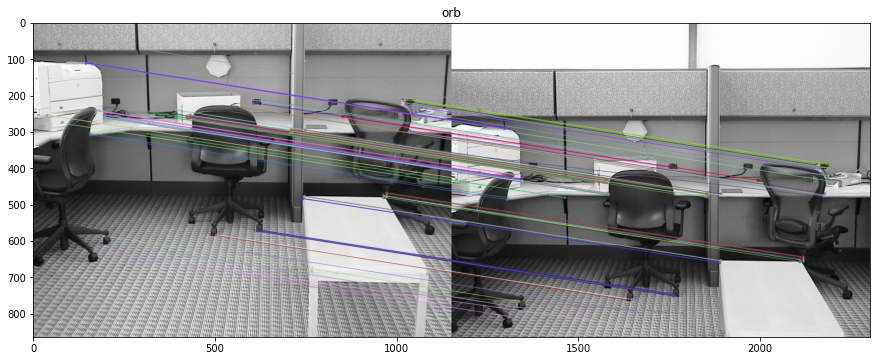

(8726, 2)


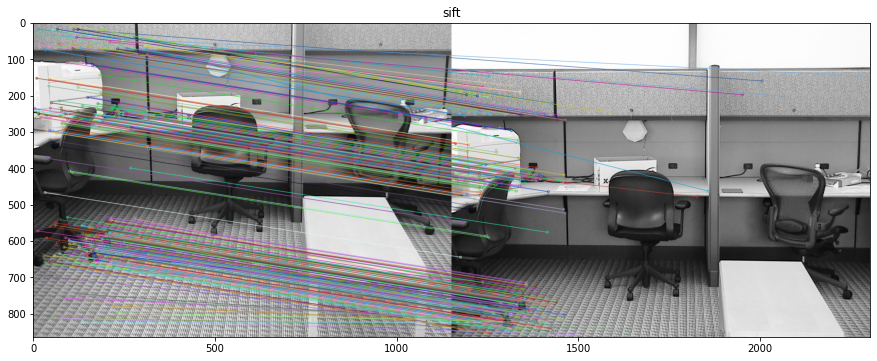

(500, 2)


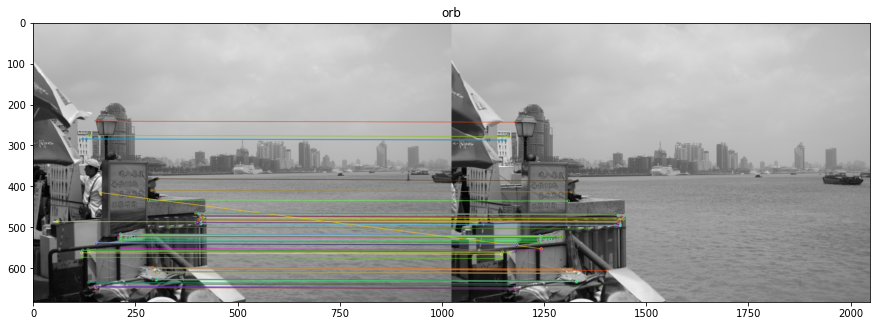

(1659, 2)


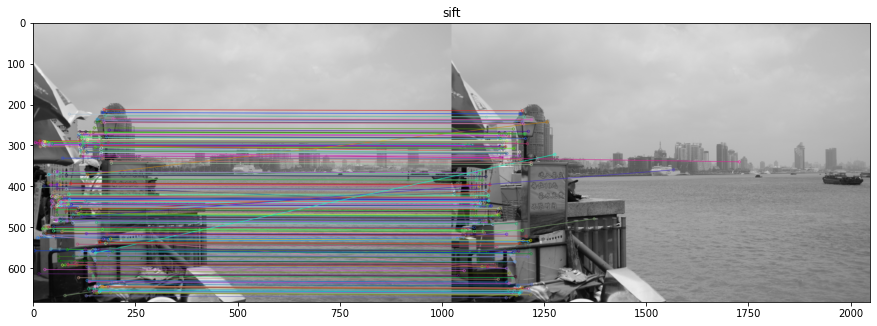

(500, 2)


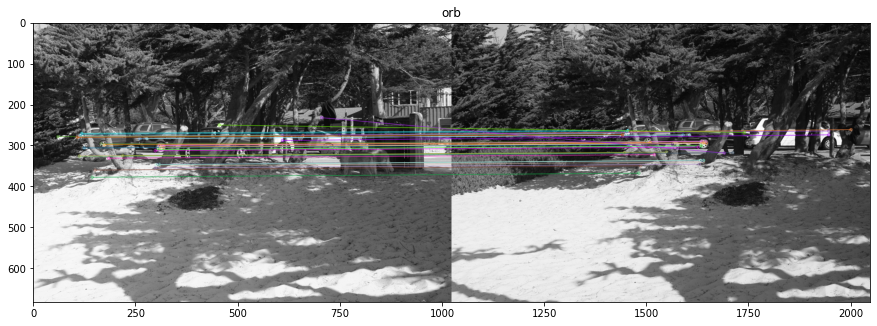

(6963, 2)


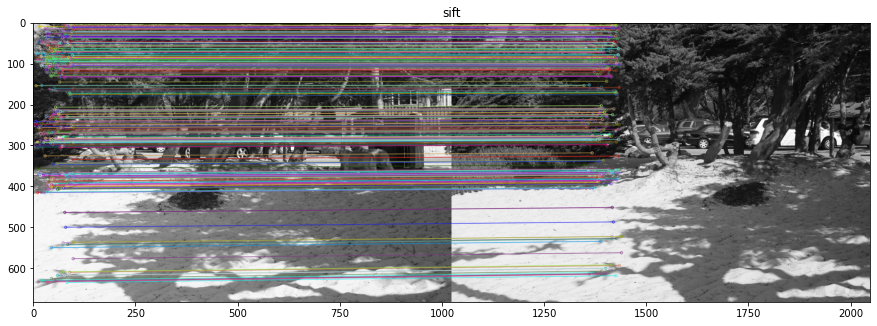

In [7]:
# img_name1 = './data/office/office-00.png'
# img_name2 = './data/office/office-01.png'

images = [    
    './data/office/office-00.png',
    './data/office/office-01.png',
    './data/shanghai/shanghai-00.png',
    './data/shanghai/shanghai-01.png',
    './data/carmel/carmel-00.png',
    './data/carmel/carmel-01.png',
]

n = len(images)//2
for i in range(n):
    img1 = cv2.imread(images[2*i],cv2.IMREAD_GRAYSCALE)          # queryImage
    img2 = cv2.imread(images[2*i + 1],cv2.IMREAD_GRAYSCALE) # trainImage
    knn_match(img1,img2,'orb',300)
    knn_match(img1,img2,'sift',300)




## 1C
c. (10 points) Instead of finding feature points independently in multiple images and then matching them, find features in the first image of a video or image sequence and then re-locate the corresponding points in the next frames using search and gradient descent (Shi and Tomasi 1994). When the number of tracked points drops below a threshold or new regions in the image become visible, find additional points to track.

In [ ]:
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2
from pprint import pprint
import matplotlib.pyplot as plt

def crop_stiched_image(stitched:np.ndarray):
    print("[INFO] cropping...")
    stitched = cv2.copyMakeBorder(stitched, 10, 10, 10, 10,
        cv2.BORDER_CONSTANT, (0, 0, 0))
		
    # convert the stitched image to grayscale and threshold it
    # such that all pixels greater than zero are set to 255
    # (foreground) while all others remain 0 (background)
    if len(stitched.shape) > 2:
        gray = cv2.cvtColor(stitched, cv2.COLOR_BGR2GRAY)
    else:
        gray = stitched
        
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

    # find all external contours in the threshold image then find
    # the *largest* contour which will be the contour/outline of
    # the stitched image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # allocate memory for the mask which will contain the
    # rectangular bounding box of the stitched image region
    mask = np.zeros(thresh.shape, dtype="uint8")
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)

    # create two copies of the mask: one to serve as our actual
    # minimum rectangular region and another to serve as a counter
    # for how many pixels need to be removed to form the minimum
    # rectangular region
    minRect = mask.copy()
    sub = mask.copy()
    # keep looping until there are no non-zero pixels left in the
    # subtracted image
    while cv2.countNonZero(sub) > 0:
        # erode the minimum rectangular mask and then subtract
        # the thresholded image from the minimum rectangular mask
        # so we can count if there are any non-zero pixels left
        minRect = cv2.erode(minRect, None)
        sub = cv2.subtract(minRect, thresh)

    # find contours in the minimum rectangular mask and then
    # extract the bounding box (x, y)-coordinates
    cnts = cv2.findContours(minRect.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    (x, y, w, h) = cv2.boundingRect(c)
    # use the bounding box coordinates to extract the our final
    # stitched image
    stitched = stitched[y:y + h, x:x + w]

    return stitched

def stitche_image(image_folder):
	print("[INFO] loading images...")
	imagePaths = sorted(list(paths.list_images(image_folder)))
	images = []

	# images to stitch list
	for imagePath in imagePaths:
		image = cv2.imread(imagePath)
		images.append(image)

	stitcher = cv2.Stitcher_create()
	(status, stitched) = stitcher.stitch(images)

	cropped = crop_stiched_image(stitched)

	return (stitched,cropped)




In [ ]:
image_folder = "./data/office"

(stitched,cropped) = stitche_image(image_folder)

plt.figure(figsize=(20, 15))
plt.imshow(stitched, cmap='gray', vmin=0, vmax=255)
plt.title("stitched")
plt.show()

plt.figure(figsize=(20, 15))
plt.imshow(cropped, cmap='gray', vmin=0, vmax=255)
plt.title("stitched-cropped")
plt.show()



In [ ]:
image_folder = "./data/carmel"

(stitched,cropped) = stitche_image(image_folder)

plt.figure(figsize=(40, 30))
plt.imshow(stitched, cmap='gray', vmin=0, vmax=255)
plt.title("stitched")
plt.show()

plt.figure(figsize=(40, 30))
plt.imshow(cropped, cmap='gray', vmin=0, vmax=255)
plt.title("stitched-cropped")
plt.show()

cv2.imwrite('./output/carmel_stitched.png',cropped)